In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings
warnings.filterwarnings("ignore")

In [4]:
def plot_power_use_profile(mode=2, sc_choice=4, output=None):
    # Plotting the power use profile for the first scenario
    # Extract the values after optimization
    time_steps = len(scenarios_data[sc_choice])
    t = np.arange(time_steps) * dt  # Time in hours

    # Retrieve the optimized generation values
    if mode==1:
        solar_gen_val = solar_capacity * scenarios_data[sc_choice]["Solar Power Factor [p.u.]"].values
    else:
        solar_gen_val = (solar_capacity.value+1) * scenarios_data[sc_choice]["Solar Power Factor [p.u.]"].values
    wind_gen_val = wind_capacity.value * scenarios_data[sc_choice]["Wind Power Factor [p.u.]"].values
    base_gen_val = baseload_capacity.value * np.ones(time_steps)
    peak_gen_val = peak_capacity.value * peak_active_mask

    try:
        storage_discharge_val = storage_discharge[sc_choice].value
        storage_charge_val = storage_charge[sc_choice].value
    except NameError:
        storage_discharge_val = np.zeros(time_steps)
        storage_charge_val = np.zeros(time_steps)

    load_follow_gen_val = load_follow_gen[sc_choice].value
    spot_load_val = spot_load[sc_choice].value

    # Calculate total generation at each time step
    # total_generation = (
    #     solar_gen_val + wind_gen_val + base_gen_val + peak_gen_val + storage_discharge_val + load_follow_gen_val + spot_load_val
    #     - storage_charge_val  # Subtract storage charge as it consumes power
    # )

    demand_mw_val = scenarios_data[sc_choice]["Demand [kW]"].values / 1000

    # Plotting
    plt.figure(figsize=(14, 7))

    plt.plot(t, demand_mw_val, label='Demand (MW)', color='black', linewidth=1.5)
    if mode==2:
        plt.stackplot(t,
                    solar_gen_val, wind_gen_val, base_gen_val, peak_gen_val,
                    storage_discharge_val - storage_charge_val,  # Net storage contribution
                    load_follow_gen_val, spot_load_val,
                    labels=['Solar', 'Wind', 'Baseload', 'Peak', 'Storage', 'Load Following', 'Spot Market'],
                    colors=['yellow', 'green', 'brown', 'orange', 'purple', 'blue', 'red'],
                    alpha=0.6)
    else:
        plt.stackplot(t,
                    solar_gen_val, wind_gen_val, base_gen_val, peak_gen_val,
                    load_follow_gen_val, spot_load_val,
                    labels=['Solar', 'Wind', 'Baseload', 'Peak', 'Load Following', 'Spot Market'],
                    colors=['yellow', 'green', 'brown', 'orange', 'blue', 'red'],
                    alpha=0.6)

    plt.xlabel('Time (hours)')
    plt.ylabel('Power (MW)')
    plt.title(f'Power Use Profile Over the Day (Scenario {sc_choice+1})')
    plt.legend(loc='upper right')
    # Add each line of output to the top corner of the plot
    textstr = '\n'.join([f"{key}: {value}" for key, value in output.items()])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.03, 0.97, textstr, transform=plt.gca().transAxes, fontsize=9,
                   verticalalignment='top', bbox=props)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Minimum expected cost: 3311.2064
realtime cost avg: 296.1522
stdev of cost: 51.5343
Wind capacity (MW): 0.1089
Baseload capacity (MW): 7.7281
Peak load capacity (MW): 0.6142
Load following capacity (MW): 1.6578


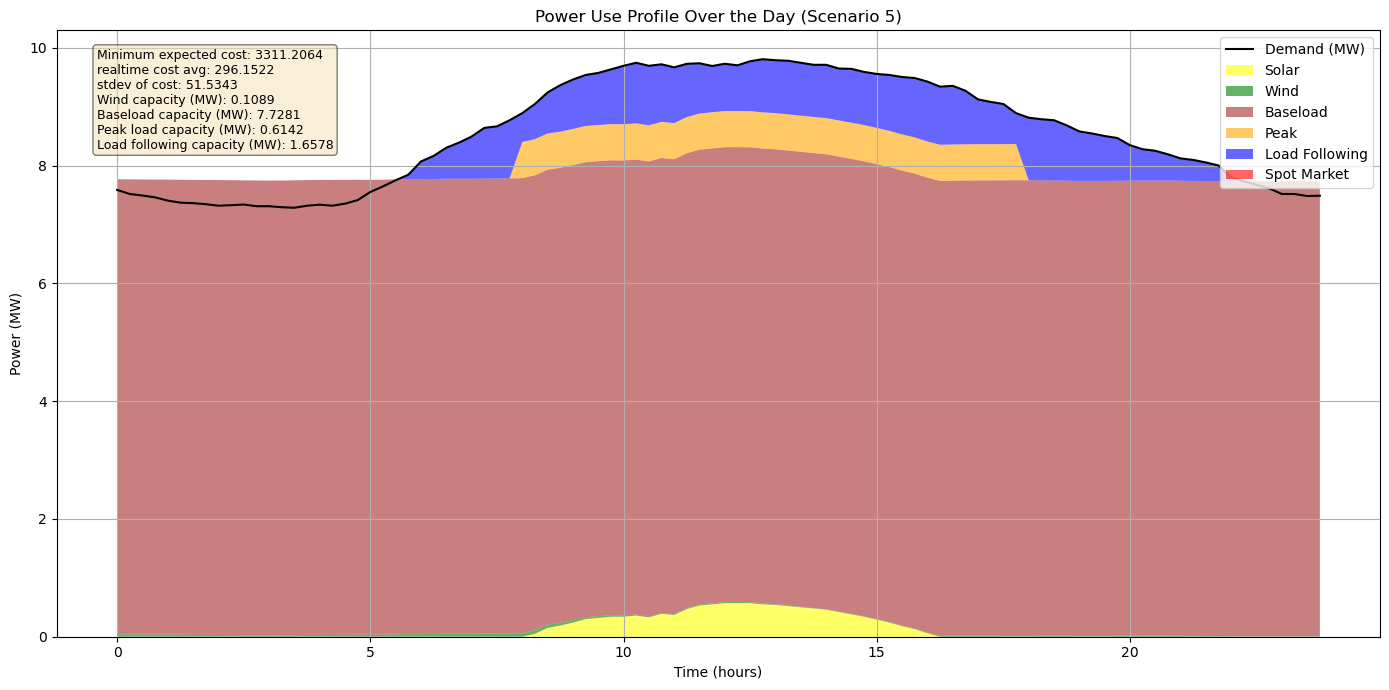

In [5]:
# Import scenario data
linecut = 96
scenario1 = pd.read_csv('data/Scenario1.csv').iloc[:linecut]
scenario2 = pd.read_csv('data/Scenario2.csv').iloc[:linecut]
scenario3 = pd.read_csv('data/Scenario3.csv').iloc[:linecut]
scenario4 = pd.read_csv('data/Scenario4.csv').iloc[:linecut]
scenario5 = pd.read_csv('data/Scenario5.csv').iloc[:linecut]
dt = 0.25 # 15-minute intervals
scenarios_data = [scenario1, scenario2, scenario3, scenario4, scenario5]

# Cost parameters
wind_cost_per_mw = 250
base_load_cost_per_mw = 360
peak_load_cost_per_mw = 200
load_following_option_fee = 50
load_following_exercise_fee = 18
service_fee = 5

max_wind_capacity = 20
max_generator_capacity = 10
solar_capacity = 1

# Decision variables (shared across scenarios)
wind_capacity = cp.Variable()
baseload_capacity = cp.Variable()
peak_capacity = cp.Variable()
load_following_capacity = cp.Variable()

# Scenario-specific real-time variables
load_follow_gen = [None] * len(scenarios_data)
spot_load = [None] * len(scenarios_data)

# Scenario-specific real-time variables
for i in range(len(scenarios_data)):
    scenario = scenarios_data[i]
    load_follow_gen[i] = cp.Variable(len(scenario), nonneg=True, name=f"load_follow_gen_{i}")
    spot_load[i] = cp.Variable(len(scenario), nonneg=True, name=f"spot_load_{i}")


# Constraints for shared variables
constraints = [
    wind_capacity >= 0,
    baseload_capacity >= 0,
    peak_capacity >= 0,
    load_following_capacity >= 0,
    wind_capacity <= max_wind_capacity,
    baseload_capacity + peak_capacity + load_following_capacity <= max_generator_capacity
]

# Fixed cost for all scenarios
fixed_cost = (
    wind_capacity * wind_cost_per_mw +
    baseload_capacity * base_load_cost_per_mw +
    peak_capacity * peak_load_cost_per_mw +
    load_following_capacity * load_following_option_fee
)

# Iterate over scenarios to define unique variables and costs
scenario_costs = []
i=0
real_time_cum = 0
for scenario in scenarios_data:
    time_steps = len(scenario)
    # Scenario-specific parameters as CVXPY constants
    demand_mw = cp.Parameter(time_steps, value=scenario["Demand [kW]"].values / 1000)
    real_time_price = cp.Parameter(time_steps, value=scenario["Real Time Price [$/MWh]"].values)
    wind_factor = cp.Parameter(time_steps, value=scenario["Wind Power Factor [p.u.]"].values)
    solar_factor = cp.Parameter(time_steps, value=scenario["Solar Power Factor [p.u.]"].values)

    # Renewable and base generation
    solar_gen = solar_capacity * solar_factor
    wind_gen = wind_capacity * wind_factor
    base_gen = baseload_capacity
    
    # Define peak gen using mask 1 for periods between 8 AM and 6 PM
    peak_active_mask = np.zeros(time_steps)
    peak_active_mask[8*4:18*4] = 1 
    peak_gen = peak_capacity * peak_active_mask

    # Calculate unmet demand
    unmet_demand = cp.pos(demand_mw - (solar_gen + wind_gen + base_gen + peak_gen))

    # # Scenario-specific real-time variables
    # load_follow_gen = cp.Variable(len(scenario), nonneg=True, name=f"load_follow_gen_{i}")
    # spot_load = cp.Variable(len(scenario), nonneg=True, name=f"spot_load_{i}")

    # Real-time cost (load-following + spot market throughout day)
    real_time_cost = cp.sum(
        load_follow_gen[i] * load_following_exercise_fee +  # Load-following cost
        spot_load[i] * (real_time_price + service_fee)  # Spot market cost
    ) * 0.25

    # Real-time constraints for this scenario
    scenario_constraints = [
        load_follow_gen[i] <= load_following_capacity,
        load_follow_gen[i] + spot_load[i] >= unmet_demand
    ]
    constraints.extend(scenario_constraints)

    # Total cost for this scenario
    real_time_cum += real_time_cost
    total_cost = fixed_cost + real_time_cost
    scenario_costs.append(total_cost)
    i+=1

# results
avg_cost = cp.sum(scenario_costs) / len(scenario_costs)
rt_avg = real_time_cum / len(scenario_costs) # avg cost to cover unmet demand

# standard deviation of cost across scenarios
cost_diff = cp.vstack([cost - avg_cost for cost in scenario_costs])
cost_sigma = cp.sqrt(cp.sum_squares(cost_diff) / len(scenario_costs))
cost_premium = 0 # PLACEHOLDER for cost premium expression

# Objective: Minimize the average cost across all scenarios
objective = cp.Minimize(avg_cost)
objective_CVaR = cp.Minimize(avg_cost+1.28*cost_sigma + cost_premium) #### CREATE OBJECTIVE BASED ON DESIRED RISK FUNCTION

# Define and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.GUROBI, OptimalityTol=1e-6)

# Output results
if problem.status == cp.OPTIMAL:
    output = {
        "Minimum expected cost": round(problem.value, 4),
        "realtime cost avg": round(rt_avg.value, 4),
        "stdev of cost": round(cost_sigma.value.item(), 4),
        "Wind capacity (MW)": round(wind_capacity.value.item(), 4),
        "Baseload capacity (MW)": round(baseload_capacity.value.item(), 4),
        "Peak load capacity (MW)": round(peak_capacity.value.item(), 4),
        "Load following capacity (MW)": round(load_following_capacity.value.item(), 4)
    }
else:
    output = {"error": problem.status}


for key, value in output.items():
    print(f"{key}: {value}")
    
plot_power_use_profile(mode=1, sc_choice=4, output=output)


Solving CVaR minimization...
CVaR value: 3370.2448
stdev of cost: 0.0
VaR threshold: 3370.2448
Wind capacity (MW): 0.2145
Baseload capacity (MW): 7.7902
Peak load capacity (MW): 0.6351
Load following capacity (MW): 1.5747


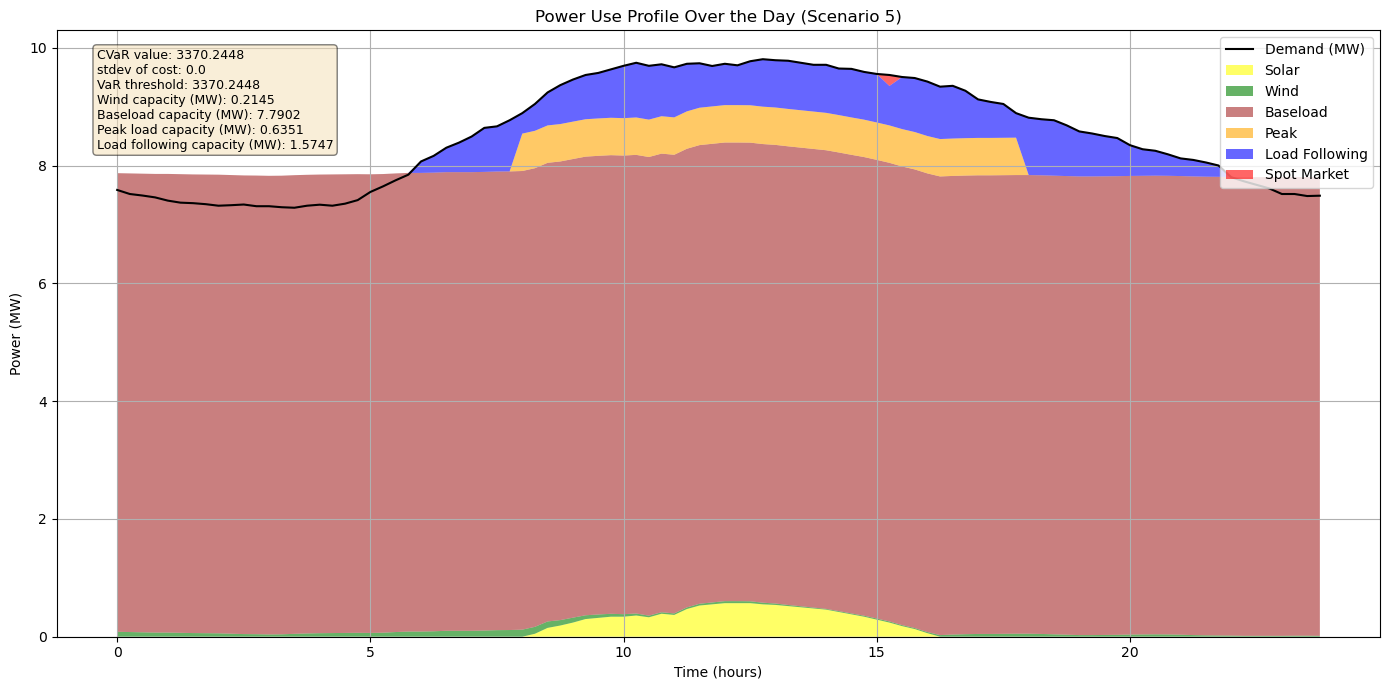

In [6]:
import numpy as np
import pandas as pd
import cvxpy as cp
import warnings
warnings.filterwarnings("ignore")

# Import scenario data
linecut = 96
scenario1 = pd.read_csv('data/Scenario1.csv').iloc[:linecut]
scenario2 = pd.read_csv('data/Scenario2.csv').iloc[:linecut]
scenario3 = pd.read_csv('data/Scenario3.csv').iloc[:linecut]
scenario4 = pd.read_csv('data/Scenario4.csv').iloc[:linecut]
scenario5 = pd.read_csv('data/Scenario5.csv').iloc[:linecut]
dt = 0.25 # 15-minute intervals
scenarios_data = [scenario1, scenario2, scenario3, scenario4, scenario5]

# Cost parameters
wind_cost_per_mw = 250
base_load_cost_per_mw = 360
peak_load_cost_per_mw = 200
load_following_option_fee = 50
load_following_exercise_fee = 18
service_fee = 5

max_wind_capacity = 20
max_generator_capacity = 10
solar_capacity = 1

# Decision variables (shared across scenarios)
wind_capacity = cp.Variable()
baseload_capacity = cp.Variable()
peak_capacity = cp.Variable()
load_following_capacity = cp.Variable()

# Scenario-specific real-time variables
load_follow_gen = [None] * len(scenarios_data)
spot_load = [None] * len(scenarios_data)

# Scenario-specific real-time variables
for i in range(len(scenarios_data)):
    scenario = scenarios_data[i]
    load_follow_gen[i] = cp.Variable(len(scenario), nonneg=True, name=f"load_follow_gen_{i}")
    spot_load[i] = cp.Variable(len(scenario), nonneg=True, name=f"spot_load_{i}")

# Constraints for shared variables
constraints = [
    wind_capacity >= 0,
    baseload_capacity >= 0,
    peak_capacity >= 0,
    load_following_capacity >= 0,
    wind_capacity <= max_wind_capacity,
    baseload_capacity + peak_capacity + load_following_capacity <= max_generator_capacity
]

# Fixed cost for all scenarios
fixed_cost = (
    wind_capacity * wind_cost_per_mw +
    baseload_capacity * base_load_cost_per_mw +
    peak_capacity * peak_load_cost_per_mw +
    load_following_capacity * load_following_option_fee
)

def safe_round(value, decimals=4):
    """Safely round a value that might be None or a numpy array"""
    try:
        if hasattr(value, 'item'):
            return round(value.item(), decimals)
        return round(value, decimals)
    except (TypeError, AttributeError):
        return value

# Iterate over scenarios to define unique variables and costs
scenario_costs = []
i=0
real_time_cum = 0
for scenario in scenarios_data:
    time_steps = len(scenario)
    # Scenario-specific parameters as CVXPY constants
    demand_mw = cp.Parameter(time_steps, value=scenario["Demand [kW]"].values / 1000)
    real_time_price = cp.Parameter(time_steps, value=scenario["Real Time Price [$/MWh]"].values)
    wind_factor = cp.Parameter(time_steps, value=scenario["Wind Power Factor [p.u.]"].values)
    solar_factor = cp.Parameter(time_steps, value=scenario["Solar Power Factor [p.u.]"].values)

    # Renewable and base generation
    solar_gen = solar_capacity * solar_factor
    wind_gen = wind_capacity * wind_factor
    base_gen = baseload_capacity
    
    # Define peak gen using mask 1 for periods between 8 AM and 6 PM
    peak_active_mask = np.zeros(time_steps)
    peak_active_mask[8*4:18*4] = 1 
    peak_gen = peak_capacity * peak_active_mask

    # Calculate unmet demand
    unmet_demand = cp.pos(demand_mw - (solar_gen + wind_gen + base_gen + peak_gen))

    # Scenario-specific real-time variables
    # load_follow_gen = cp.Variable(len(scenario), nonneg=True, name=f"load_follow_gen_{i}")
    # spot_load = cp.Variable(len(scenario), nonneg=True, name=f"spot_load_{i}")

    # Real-time cost (load-following + spot market throughout day)
    real_time_cost = cp.sum(
        load_follow_gen[i] * load_following_exercise_fee +  # Load-following cost
        spot_load[i] * (real_time_price + service_fee)  # Spot market cost
    ) * 0.25

    # Real-time constraints for this scenario
    scenario_constraints = [
        load_follow_gen[i] <= load_following_capacity,
        load_follow_gen[i] + spot_load[i] >= unmet_demand
    ]
    constraints.extend(scenario_constraints)

    # Total cost for this scenario
    real_time_cum += real_time_cost
    total_cost = fixed_cost + real_time_cost
    scenario_costs.append(total_cost)
    i+=1

# results
avg_cost = cp.sum(scenario_costs) / len(scenario_costs)
rt_avg = real_time_cum / len(scenario_costs) # avg cost to cover unmet demand

# standard deviation of cost across scenarios
cost_diff = cp.vstack([cost - avg_cost for cost in scenario_costs])
cost_sigma = cp.sqrt(cp.sum_squares(cost_diff) / len(scenario_costs))

#cost_premium = 0 # PLACEHOLDER for cost premium expression

# CVaR implementation 
beta = 0.8  # CVaR confidence level (focusing on worst 20% of scenarios)
alpha = cp.Variable()  # VaR threshold
# alpha = avg_cost + 1.28*cost_sigma  # VaR threshold mean+1.28*sigma
scenario_costs_expr = cp.vstack(scenario_costs)
# M = cp.Variable(len(scenarios_data), nonneg=True)  # Excess losses for each scenario
# M = cp.Parameter(len(scenarios_data), nonneg=True)  # Excess losses for each scenario
M = scenario_costs_expr - alpha
postM = cp.pos(M)
# CVaR_loss = cp.max(scenario_costs_expr)

# Calculate CVaR objective with proper weighting
CVaR_loss = alpha + (1/(len(scenarios_data)*(1-beta))) * cp.sum(postM)

# Define two separate objectives for our two optimization problems
objective_expected = cp.Minimize(avg_cost)  # Original expected value minimization
objective_CVaR = cp.Minimize(CVaR_loss)  # CVaR minimization

# Define and solve both problems
# problem_expected = cp.Problem(objective_expected, constraints)
problem_CVaR = cp.Problem(objective_CVaR, constraints)

# # Solve expected value problem
# print("Solving expected value minimization...")
# problem_expected.solve(solver=cp.GUROBI, OptimalityTol=1e-6)
# print("Expected (Avg cost loss) Results:")
# output = {
#         "Minimum expected cost": safe_round(problem_expected.value),
#         "realtime cost avg": safe_round(rt_avg.value),
#         "stdev of cost": safe_round(cost_sigma.value),
#         "Wind capacity (MW)": safe_round(wind_capacity.value),
#         "Baseload capacity (MW)": safe_round(baseload_capacity.value),
#         "Peak load capacity (MW)": safe_round(peak_capacity.value),
#         "Load following capacity (MW)": safe_round(load_following_capacity.value)
#     }
# for key, value in output.items():
#     print(f"{key}: {value}")

# Solve CVaR problem
print("\nSolving CVaR minimization...")
problem_CVaR.solve(solver=cp.GUROBI)
# print(len(M))

# Output results with both solutions
if problem_CVaR.status == cp.OPTIMAL:
    output =  {
                "CVaR value": safe_round(problem_CVaR.value),
                "stdev of cost": safe_round(cost_sigma.value),
                "VaR threshold": safe_round(alpha.value),
                "Wind capacity (MW)": safe_round(wind_capacity.value),
                "Baseload capacity (MW)": safe_round(baseload_capacity.value),
                "Peak load capacity (MW)": safe_round(peak_capacity.value),
                "Load following capacity (MW)": safe_round(load_following_capacity.value)
            }

for key, value in output.items():
    print(f"{key}: {value}")

plot_power_use_profile(mode=1, sc_choice=4, output=output)

#### Renewable Study
Now, lets investigate the feasibility of using extended solar with onsite storage (assuming battery) of proportionate size. 
Assuming storage has no degradation over a 10year lifespan with only upfront cost of 25000 + 1000/MW... ie set costs to 10yr sum

Avg expected cost: 3293.7218
Standard Deviation of cost: 49.1091
Wind capacity (MW): 0.0
Baseload capacity (MW): 7.753
Peak load capacity (MW): 0.6653
Load following capacity (MW): 1.5818
Extra Solar capacity (MW): 0.0
Storage capacity (MWh): 0.2992
Average Energy Use (MWh): 210.6649
Average CO2-emitting Energy Use (MWh): 207.883
CO2 Tax per kg ($): 0.0
Ratio of CO2-emitting Energy to Total Energy: 0.9868


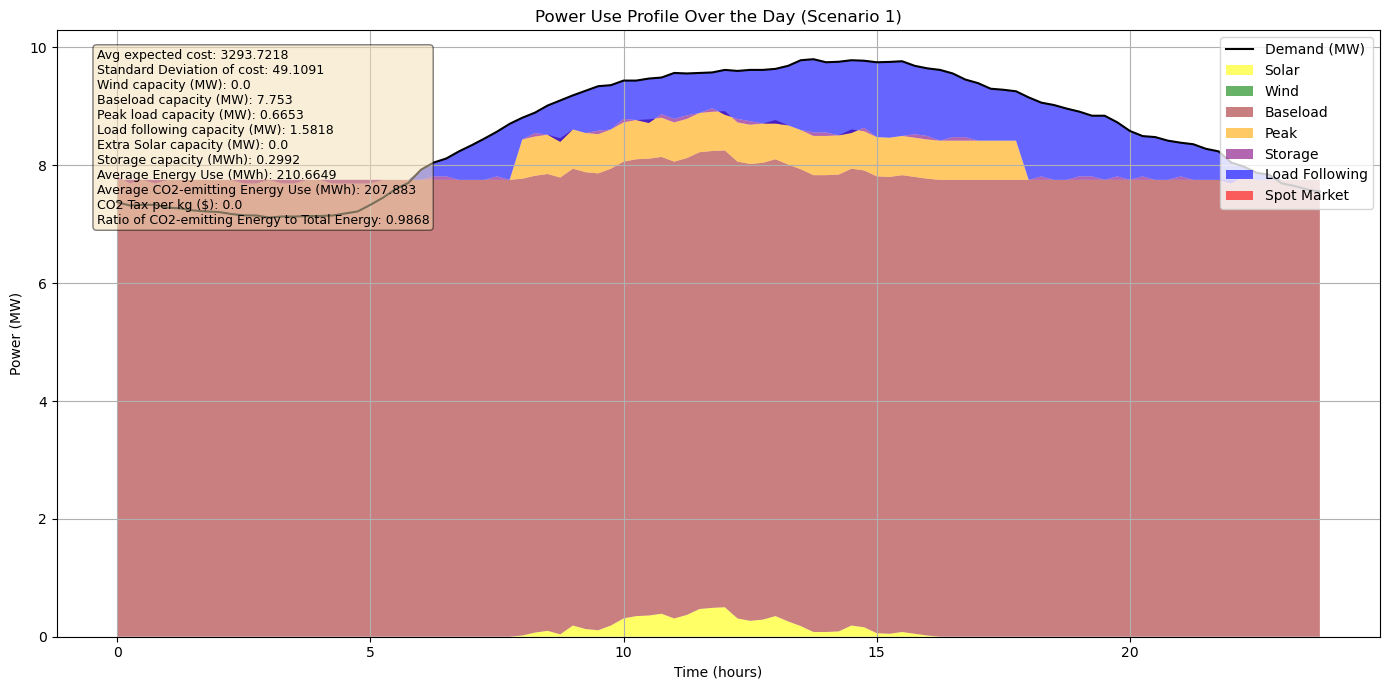

In [7]:
# Given Cost parameters
wind_cost_per_mw = 250
base_load_cost_per_mw = 360
peak_load_cost_per_mw = 200
load_following_option_fee = 50
load_following_exercise_fee = 18
service_fee = 5

# CO2 Cost Premium
MWh_to_kgCO2 = 185  # US avg kg CO2 per MWh https://www.eia.gov/tools/faqs/faq.php?id=74&t=11 
co2_cost_perkg = 0.00 # cost per kg CO2 generation

# Solar cost parameters NEEDS WORK
solar_fixed_cost = 0  # Upfront cost
solar_cost_per_mw = 770000  # Cost per MW of solar capacity https://www.solarreviews.com/blog/how-does-utility-scale-solar-work
solar_cost_per_mw = 1.25*solar_cost_per_mw  # 1.25million... Cost per MW of solar generation with offsite transmission ^^^
solar_lifespan_years = 30  # Lifespan over which to amortize the storage cost
max_solar_capacity = 100 # Maximum solar capacity, limited by surface area
solar_capacity = cp.Variable(nonneg=True)

# Storage cost parameters NEEDS WORK
storage_fixed_cost = 0  # Upfront cost
storage_cost_per_mwh = 350000  # Cost per MWh of storage capacity https://www.nrel.gov/docs/fy23osti/85332.pdf
storage_lifespan_years = 20  # Lifespan over which to amortize the storage cost
max_storage_capacity = 150  # Maximum storage capacity, limited by space
storage_capacity = cp.Variable(nonneg=True)
storage_cd_rate = cp.Parameter(nonneg=True)  # Charge/discharge rate NEEDS WORK
storage_cd_rate = 0.20*storage_capacity # 15% of storage capacity, in MW (assuming 8hr charge/discharge time)

max_wind_capacity = 20
max_generator_capacity = 10

# Decision variables (shared across scenarios)
wind_capacity = cp.Variable(nonneg=True)
baseload_capacity = cp.Variable(nonneg=True)
peak_capacity = cp.Variable(nonneg=True)
load_following_capacity = cp.Variable(nonneg=True)

# Scenario-specific real-time variables
load_follow_gen = [None] * len(scenarios_data)
spot_load = [None] * len(scenarios_data)
storage_charge = [None] * len(scenarios_data)
storage_discharge = [None] * len(scenarios_data)
storage_soc = [None] * len(scenarios_data)

# Scenario-specific real-time variables
for i in range(len(scenarios_data)):
    scenario = scenarios_data[i]
    load_follow_gen[i] = cp.Variable(len(scenario), nonneg=True, name=f"load_follow_gen_{i}")
    spot_load[i] = cp.Variable(len(scenario), nonneg=True, name=f"spot_load_{i}")

    # Scenario-specific variables for storage operation
    storage_charge[i] = cp.Variable(time_steps, nonneg=True, name=f"storage_charge_{i}")
    storage_discharge[i] = cp.Variable(time_steps, nonneg=True, name=f"storage_discharge_{i}")
    storage_soc[i] = cp.Variable(time_steps, name=f"storage_soc_{i}")

# Constraints for shared variables
constraints = [
    wind_capacity >= 0,
    baseload_capacity >= 0,
    peak_capacity >= 0,
    load_following_capacity >= 0,
    storage_capacity >= 0,
    solar_capacity >= 0,
    solar_capacity <= max_solar_capacity,
    storage_capacity <= max_storage_capacity,
    wind_capacity <= max_wind_capacity,
    baseload_capacity + peak_capacity + load_following_capacity <= max_generator_capacity
]

# Fixed cost for all scenarios (annualized storage cost over its lifespan)
storage_cost = (storage_fixed_cost + storage_cost_per_mwh * storage_capacity) / (storage_lifespan_years*365)
solar_cost = (solar_fixed_cost + solar_cost_per_mw * solar_capacity) / (solar_lifespan_years*365)

fixed_cost = (
    wind_capacity * wind_cost_per_mw +
    (baseload_capacity * base_load_cost_per_mw +
    peak_capacity * peak_load_cost_per_mw +
    load_following_capacity * load_following_option_fee) +
    solar_cost + storage_cost
)

# Iterate over scenarios to define unique variables and costs
scenario_costs = []
energy_total = []
energy_dirty = []
real_time_cum = 0
i = 0
for scenario in scenarios_data:
    time_steps = len(scenario)

    # Scenario-specific parameters as CVXPY constants
    demand_mw = cp.Parameter(time_steps, value=scenario["Demand [kW]"].values / 1000)
    real_time_price = cp.Parameter(time_steps, value=scenario["Real Time Price [$/MWh]"].values)
    wind_factor = cp.Parameter(time_steps, value=scenario["Wind Power Factor [p.u.]"].values)
    solar_factor = cp.Parameter(time_steps, value=scenario["Solar Power Factor [p.u.]"].values)

    # Renewable and base generation
    solar_gen = (solar_capacity+1) * solar_factor  # Adding 1 for free 1MW preinstalled capacity
    wind_gen = wind_capacity * wind_factor
    base_gen = baseload_capacity

    # Define peak gen using mask 1 for periods between 8 AM and 6 PM
    peak_active_mask = np.zeros(time_steps)
    peak_active_mask[8*4:18*4] = 1  # Assuming data is in 15-minute intervals
    peak_gen = peak_capacity * peak_active_mask

    # # Scenario-specific variables for storage operation
    # storage_charge = cp.Variable(time_steps, nonneg=True, name=f"storage_charge_{i}")
    # storage_discharge = cp.Variable(time_steps, nonneg=True, name=f"storage_discharge_{i}")
    # storage_soc = cp.Variable(time_steps, name=f"storage_soc_{i}")


    # Storage operational constraints
    for t in range(time_steps): # for each 15min time step
        # Storage state of charge dynamics
        if t == 0:
            # Initial storage state of charge (assuming starting at half-charge)
            constraints += [storage_soc[i][0] == storage_capacity / 2]
        else:
            constraints += [
                storage_soc[i][t] == storage_soc[i][t-1] + (storage_charge[i][t] - storage_discharge[i][t])*dt
            ]
        # Storage capacity constraints
        constraints += [
            storage_soc[i][t] >= 0,
            storage_soc[i][t] <= storage_capacity,
            storage_charge[i][t] <= storage_cd_rate,
            storage_discharge[i][t] <= storage_cd_rate
        ]

    # # Scenario-specific real-time variables
    # load_follow_gen = cp.Variable(time_steps, nonneg=True, name=f"load_follow_gen_{i}")
    # spot_load = cp.Variable(time_steps, nonneg=True, name=f"spot_load_{i}")

    # Energy balance constraints
    for t in range(time_steps):
        # Total generation and demand balance
        constraints += [
            solar_gen[t] + wind_gen[t] + base_gen + peak_gen[t] + storage_discharge[i][t] + load_follow_gen[i][t] + spot_load[i][t]
            >= demand_mw[t] + storage_charge[i][t]
        ]

    # Real-time constraints for load following and spot market
    constraints += [
        load_follow_gen[i] <= load_following_capacity
    ]

    # Real-time cost (load-following + spot market throughout the day)
    real_time_cost = cp.sum(
        load_follow_gen[i] * load_following_exercise_fee +
        spot_load[i] * (real_time_price + service_fee)
    ) * 0.25  # Assuming 15-minute intervals

    # CO2 emissions cost
    e = sum(spot_load[i][t] for t in range(time_steps)) + sum(base_gen for t in range(time_steps)) + sum(peak_gen[t] for t in range(time_steps)) + sum(load_follow_gen[i][t] for t in range(time_steps))
    e_CO2scen = e * 0.25
    total_e = sum(solar_gen[t] + wind_gen[t] + base_gen + peak_gen[t] + storage_discharge[i][t] + load_follow_gen[i][t] + spot_load[i][t] for t in range(time_steps))*0.25

    # Total cost for this scenario
    total_cost = fixed_cost + real_time_cost + e_CO2scen*MWh_to_kgCO2*co2_cost_perkg
    energy_total.append(total_e)
    energy_dirty.append(e_CO2scen)
    scenario_costs.append(total_cost)
    real_time_cum += real_time_cost
    i += 1

# Results
avg_Energy = sum(energy_total) / len(scenarios_data)
avg_MWh_CO2 = sum(energy_dirty) / len(scenarios_data)
avg_cost = cp.sum(scenario_costs) / len(scenario_costs)
rt_avg = real_time_cum / len(scenario_costs)  # Average cost to cover unmet demand

# Standard deviation of cost across scenarios
cost_diff = cp.vstack([cost - avg_cost for cost in scenario_costs])
cost_sigma = cp.sqrt(cp.sum_squares(cost_diff) / len(scenario_costs))
cost_premium = 0  # Placeholder for cost premium expression

# Objective: Minimize the average cost across all scenarios
objective = cp.Minimize(avg_cost)
# objective_CVaR = cp.Minimize(avg_cost + 1.28 * cost_sigma + cost_premium)  # Risk function if needed

# Define and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.GUROBI, OptimalityTol=1e-9)

# Output results
if problem.status == cp.OPTIMAL:
    output = {
        "Avg expected cost": round(problem.value, 4),
        # "Real-time cost average": round(rt_avg.value, 4),
        "Standard Deviation of cost": round(cost_sigma.value.item(), 4),
        "Wind capacity (MW)": round(wind_capacity.value.item(), 4),
        "Baseload capacity (MW)": round(baseload_capacity.value.item(), 4),
        "Peak load capacity (MW)": round(peak_capacity.value.item(), 4),
        "Load following capacity (MW)": round(load_following_capacity.value.item(), 4),
        "Extra Solar capacity (MW)": round(solar_capacity.value.item(), 4),
        "Storage capacity (MWh)": round(storage_capacity.value.item(), 4),
        "Average Energy Use (MWh)": round(avg_Energy.value, 4),
        "Average CO2-emitting Energy Use (MWh)": round(avg_MWh_CO2.value, 4),
        "CO2 Tax per kg ($)": round(co2_cost_perkg, 4),
        "Ratio of CO2-emitting Energy to Total Energy": round(avg_MWh_CO2.value/avg_Energy.value, 4)
    }
else:
    output = {"error": problem.status}

for key, value in output.items():
    print(f"{key}: {value}")

plot_power_use_profile(mode=2, sc_choice=0, output=output)